In [42]:
import cv2
import numpy as np
import os

# Define the block size. BLOCK_SIZE = 2 as requested.
# This is the core parameter controlling the *inherent loss* of the block-averaging method.
BLOCK_SIZE = 2

# Define the JPEG quality for the output image.
# Lower quality -> Smaller file size, more JPEG compression artifacts (additional loss).
OUTPUT_JPEG_QUALITY = 60 # Start with 70, you may need to adjust this (e.g., 60, 50)

def get_block_average_color(image, y_start, x_start, block_size, img_h, img_w):
    """Calculates the average BGR color for a block."""
    y_end = min(y_start + block_size, img_h)
    x_end = min(x_start + block_size, img_w)
    block = image[y_start:y_end, x_start:x_end]

    if block.size == 0:
         return np.array([0, 0, 0], dtype=np.uint8)

    avg_color = block.mean(axis=(0, 1))
    return avg_color.astype(np.uint8)

def compress_image_block_average(image_path, output_path="test_blockavg.npz", block_size=BLOCK_SIZE):
    """
    Compresses a color image by dividing it into blocks and storing the
    average color of each block. Saves using numpy's compressed format (.npz).

    This process is LOSSY for the original pixel data when BLOCK_SIZE > 1.
    Compression efficiency is seen in the size of the .npz file.
    """
    try:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            print(f"[!] Error: Could not load image from {image_path}")
            return

        img_h, img_w, img_c = image.shape

        # Calculate dimensions of the block grid
        grid_h = (img_h + block_size - 1) // block_size
        grid_w = (img_w + block_size - 1) // block_size

        # Array to store the average color (B, G, R) for each block
        # Storing 3 bytes per block. Original raw data was 3 bytes per pixel.
        # Data reduction factor approx (block_size * block_size).
        block_avg_colors = np.zeros((grid_h, grid_w, 3), dtype=np.uint8)

        print(f"Processing image {img_w}x{img_h} ({img_c} channels) in {block_size}x{block_size} blocks...")

        for i in range(grid_h):
            for j in range(grid_w):
                y_start = i * block_size
                x_start = j * block_size
                avg_color = get_block_average_color(image, y_start, x_start, block_size, img_h, img_w)
                block_avg_colors[i, j] = avg_color

        # Save original dimensions, block size, and the block average colors
        # using numpy's compressed format (.npz) - this applies zlib compression.
        np.savez_compressed(output_path,
                            original_height=img_h,
                            original_width=img_w,
                            block_size=block_size,
                            block_avg_colors=block_avg_colors)

        print(f"[✓] Processed {image_path}. Saved block average colors data to {output_path}")

        # --- Report Sizes ---
        original_image_file_size = os.path.getsize(image_path)
        compressed_npz_size = os.path.getsize(output_path)
        original_raw_size = img_h * img_w * img_c # Estimate raw size

        print(f"\n--- Compression Metrics (of your method) ---")
        print(f"    Original image file size (e.g., JPEG): {original_image_file_size} bytes")
        print(f"    Estimated original raw pixel data size: {original_raw_size} bytes")
        print(f"    Compressed data file size (.npz): {compressed_npz_size} bytes")

        if original_raw_size > 0:
             print(f"    Compression ratio (vs. raw data): {original_raw_size / compressed_npz_size:.2f}x")

        print(f"\n    Note: Your block-averaging method reduces the data needed to represent the image areas.")
        print(f"    The size of the output '.npz' file ({compressed_npz_size} bytes)")
        print(f"    compared to the original image file ({original_image_file_size} bytes)")
        print(f"    depends on the original file's existing compression.")


    except Exception as e:
        print(f"[!] An error occurred during compression: {e}")

def decompress_block_average_to_image(input_path="test_blockavg.npz", output_path="decompressed_blockavg.jpg", jpeg_quality=OUTPUT_JPEG_QUALITY):
    """
    Decompresses block average color data back into a color image.
    Saves the resulting image as JPEG with specified quality.
    """
    try:
        # Load the data from the numpy compressed file
        data = np.load(input_path)

        img_h = data['original_height']
        img_w = data['original_width']
        block_size = data['block_size']
        block_avg_colors = data['block_avg_colors'] # Shape (grid_h, grid_w, 3)

        grid_h, grid_w, _ = block_avg_colors.shape

        # Create a blank image with the original dimensions
        reconstructed_image = np.zeros((img_h, img_w, 3), dtype=np.uint8)

        print(f"Reconstructing image {img_w}x{img_h} from {grid_w}x{grid_h} blocks (BLOCK_SIZE={block_size})...")

        # Iterate through the stored block average colors
        for i in range(grid_h):
            for j in range(grid_w):
                y_start = i * block_size
                x_start = j * block_size
                y_end = min(y_start + block_size, img_h)
                x_end = min(x_start + block_size, img_w)

                avg_color = block_avg_colors[i, j]

                # Fill the corresponding block area
                reconstructed_image[y_start:y_end, x_start:x_end] = avg_color

        # Save the reconstructed color image as JPEG
        # We adjust the JPEG quality here to try and control the output file size.
        # Lowering quality adds more compression artifacts to the output image.
        cv2.imwrite(output_path, reconstructed_image, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])

        print(f"[✓] Decompressed from {input_path} and saved as JPEG: {output_path}")

        # --- Report Decompression Metrics ---
        decompressed_image_file_size = os.path.getsize(output_path)
        print(f"\n--- Decompression Metrics ---")
        print(f"    Decompressed image file size ({os.path.basename(output_path)}): {decompressed_image_file_size} bytes (saved with JPEG quality {jpeg_quality})")
        print(f"    Note: The output image shows the block averaging loss, PLUS additional loss from JPEG compression at quality {jpeg_quality}.")


    except FileNotFoundError:
        print(f"[!] Error: Input file not found at {input_path}")
    except KeyError as e:
         print(f"[!] Error: Missing expected key in the compressed file: {e}")
    except Exception as e:
        print(f"[!] An error occurred during decompression: {e}")

if __name__ == "__main__":
    # Ensure you have a 'test.jpg' image in the same directory
    # Or change the path to your image file. Use a color image!
    input_image = "test2.jpg" # Make sure test.jpg is a color image
    compressed_file = "test_blockavg2.npz"
    decompressed_image_jpg = "decompressed_blockavg2.jpg"

    # --- Compression (Block Averaging) ---
    # BLOCK_SIZE=2 is set at the top.
    print("--- Running Block Average Compression ---")
    compress_image_block_average(input_image, compressed_file) # Uses BLOCK_SIZE from top

    print("\n--- Running Block Average Decompression ---")
    # Adjust OUTPUT_JPEG_QUALITY at the top or pass it here to control the output JPG size
    decompress_block_average_to_image(compressed_file, decompressed_image_jpg, jpeg_quality=OUTPUT_JPEG_QUALITY)

    print("\n--- Summary ---")
    print(f"Original image: {input_image} (size reported during compression)")
    print(f"Compressed data: {compressed_file} (size reported during compression)")
    print(f"Decompressed image: {decompressed_image_jpg} (size reported during decompression)")
    print(f"\nTo evaluate the compression achieved by your block method, compare the size of '{compressed_file}' to the original image's *estimated raw data size*.")
    print(f"To achieve a decompressed image file size smaller than the original '{input_image}' file, we save the output JPEG at a lower quality ({OUTPUT_JPEG_QUALITY}), which adds more loss.")
    print(f"Visually compare '{input_image}' and '{decompressed_image_jpg}' to see the combined loss (block averaging + lower quality JPEG).")

--- Running Block Average Compression ---
Processing image 3000x2003 (3 channels) in 2x2 blocks...
[✓] Processed test2.jpg. Saved block average colors data to test_blockavg2.npz

--- Compression Metrics (of your method) ---
    Original image file size (e.g., JPEG): 342433 bytes
    Estimated original raw pixel data size: 18027000 bytes
    Compressed data file size (.npz): 1710889 bytes
    Compression ratio (vs. raw data): 10.54x

    Note: Your block-averaging method reduces the data needed to represent the image areas.
    The size of the output '.npz' file (1710889 bytes)
    compared to the original image file (342433 bytes)
    depends on the original file's existing compression.

--- Running Block Average Decompression ---
Reconstructing image 3000x2003 from 1500x1002 blocks (BLOCK_SIZE=2)...
[✓] Decompressed from test_blockavg2.npz and saved as JPEG: decompressed_blockavg2.jpg

--- Decompression Metrics ---
    Decompressed image file size (decompressed_blockavg2.jpg): 219418 

## Metrics Time Buddy

--- Starting Image Compression and Analysis ---
Using input image: test.jpg
Configuration: BLOCK_SIZE=2, Output JPEG Quality=60
Compressing 534x400 (3 channels) with 2x2 blocks...
[✓] Saved block average colors data to test_blockavg.npz
Reconstructing block-averaged array 534x400 from 267x200 blocks (BLOCK_SIZE=2)...
[✓] Reconstructed block-averaged array in memory.
[✓] Final decompressed JPEG saved to decompressed_blockavg.jpg (quality=60)

--- Displaying Images ---


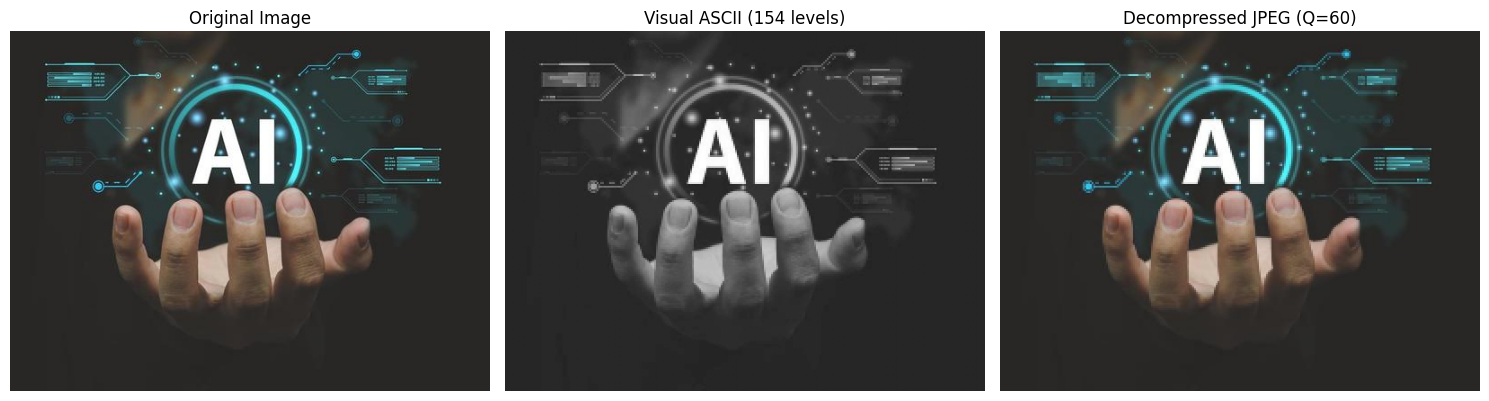

TypeError: display_metrics_table() missing 1 required positional argument: 'quality_metrics'

In [40]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- Configuration ---
BLOCK_SIZE = 2 # As requested. Controls the inherent loss of the block-averaging method.
OUTPUT_JPEG_QUALITY = 60 # Controls the final JPEG loss and size. Adjust to hit target size.

# ASCII gradient for *visualizing* the mapping effect, not for compression data itself
ASCII_GRADIENT = " ░▒▓█@#$%&*()_+=-|}{[]:;<>.,~`abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789" # A common, simple gradient for visualization
GRADIENT_LEN = len(ASCII_GRADIENT)

# --- Helper Functions (Core Logic) ---

def get_block_average_color(image, y_start, x_start, block_size, img_h, img_w):
    """Calculates the average BGR color for a block."""
    y_end = min(y_start + block_size, img_h)
    x_end = min(x_start + block_size, img_w)
    block = image[y_start:y_end, x_start:x_end]

    if block.size == 0:
         return np.array([0, 0, 0], dtype=np.uint8)

    avg_color = block.mean(axis=(0, 1))
    return avg_color.astype(np.uint8)

def compress_image_block_average(image_path, output_path="test_blockavg.npz", block_size=BLOCK_SIZE):
    """
    Compresses a color image by dividing it into blocks and storing the
    average color of each block. Saves using numpy's compressed format (.npz).

    Returns the original image array and compression metrics.
    """
    metrics = {}
    original_image = None
    try:
        original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if original_image is None:
            print(f"[!] Error: Could not load image from {image_path}")
            return None, metrics # Return None image on error

        img_h, img_w, img_c = original_image.shape

        # Calculate dimensions of the block grid
        grid_h = (img_h + block_size - 1) // block_size
        grid_w = (img_w + block_size - 1) // block_size

        block_avg_colors = np.zeros((grid_h, grid_w, 3), dtype=np.uint8)

        print(f"Compressing {img_w}x{img_h} ({img_c} channels) with {block_size}x{block_size} blocks...")

        for i in range(grid_h):
            for j in range(grid_w):
                y_start = i * block_size
                x_start = j * block_size
                avg_color = get_block_average_color(original_image, y_start, x_start, block_size, img_h, img_w)
                block_avg_colors[i, j] = avg_color

        np.savez_compressed(output_path,
                            original_height=img_h,
                            original_width=img_w,
                            block_size=block_size,
                            block_avg_colors=block_avg_colors)

        print(f"[✓] Saved block average colors data to {output_path}")

        # --- Calculate Compression Metrics ---
        metrics['original_image_file_size'] = os.path.getsize(image_path) if os.path.exists(image_path) else 0
        metrics['compressed_npz_size'] = os.path.getsize(output_path) if os.path.exists(output_path) else 0
        metrics['original_raw_size_estimate'] = img_h * img_w * img_c # Estimate raw size

        if metrics['original_raw_size_estimate'] > 0 and metrics['compressed_npz_size'] > 0:
             metrics['compression_ratio_vs_raw'] = metrics['original_raw_size_estimate'] / metrics['compressed_npz_size']
        else:
             metrics['compression_ratio_vs_raw'] = float('nan') # Not applicable or error

        if metrics['original_image_file_size'] > 0 and metrics['compressed_npz_size'] > 0:
            metrics['size_ratio_vs_original_file'] = metrics['compressed_npz_size'] / metrics['original_image_file_size']
        else:
            metrics['size_ratio_vs_original_file'] = float('nan') # Not applicable or error

        metrics['block_size'] = block_size # Store block size here too

    except Exception as e:
        print(f"[!] An error occurred during compression: {e}")
        original_image = None # Ensure image is None on error

    return original_image, metrics # Return original image array

def decompress_block_average_to_array(input_path="test_blockavg.npz"):
    """
    Decompresses block average color data back into a color image array.
    Does NOT save to a file. Returns the reconstructed array and dimensions.
    """
    reconstructed_image_array = None
    img_h, img_w, block_size = None, None, None
    try:
        data = np.load(input_path)

        img_h = data['original_height']
        img_w = data['original_width']
        block_size = data['block_size']
        block_avg_colors = data['block_avg_colors'] # Shape (grid_h, grid_w, 3)

        grid_h, grid_w, _ = block_avg_colors.shape

        reconstructed_image_array = np.zeros((img_h, img_w, 3), dtype=np.uint8)

        print(f"Reconstructing block-averaged array {img_w}x{img_h} from {grid_w}x{grid_h} blocks (BLOCK_SIZE={block_size})...")

        for i in range(grid_h):
            for j in range(grid_w):
                y_start = i * block_size
                x_start = j * block_size
                y_end = min(y_start + block_size, img_h)
                x_end = min(x_start + block_size, img_w)

                avg_color = block_avg_colors[i, j]
                reconstructed_image_array[y_start:y_end, x_start:x_end] = avg_color

        print(f"[✓] Reconstructed block-averaged array in memory.")

    except FileNotFoundError:
        print(f"[!] Error: Input file not found at {input_path}")
    except KeyError as e:
         print(f"[!] Error: Missing expected key in the compressed file: {e}")
    except Exception as e:
        print(f"[!] An error occurred during decompression: {e}")

    return reconstructed_image_array, img_h, img_w, block_size # Return the array and original dimensions/block_size

def create_visual_ascii_image(block_averaged_image_array, gradient=ASCII_GRADIENT):
    """
    Creates a grayscale image array that visualizes the block-averaged image
    mapped to discrete levels like ASCII art.
    """
    if block_averaged_image_array is None:
        return None

    try:
        # Convert block-averaged image to grayscale
        gray_image = cv2.cvtColor(block_averaged_image_array, cv2.COLOR_BGR2GRAY)

        # Map grayscale values to discrete levels based on gradient length
        # Use numpy operations for efficiency
        gradient_len = len(gradient)
        # Calculate indices: (value / 255.0) * (gradient_len - 1)
        indices = np.clip((gray_image / 255.0) * (gradient_len - 1), 0, gradient_len - 1).astype(int)

        # Map indices back to pixel values (0-255) representing these discrete levels
        # Use numpy operations
        visual_ascii_gray = np.clip((indices / (gradient_len - 1.0)) * 255.0, 0, 255).astype(np.uint8)

        # Return as a single channel (grayscale) image array
        return visual_ascii_gray

    except Exception as e:
        print(f"[!] An error occurred creating visual ASCII image: {e}")
        return None


# --- Metric Calculation and Display ---

def calculate_quality_metrics(original_image, reconstructed_image):
    """Calculates PSNR and SSIM between two BGR image arrays."""
    metrics = {}
    if original_image is None or reconstructed_image is None:
        print("[!] Cannot calculate quality metrics: one or both images are invalid.")
        return metrics

    try:
        # Ensure images have same dimensions
        if original_image.shape != reconstructed_image.shape:
             print("[!] Image dimensions mismatch for quality metrics calculation.")
             # Attempt to resize reconstructed image if necessary
             # This could happen if edge handling slightly changed dimensions
             if original_image.shape[:2] == reconstructed_image.shape[:2]:
                 print("    Shape mismatch in channels, but HxW match. Should not happen with BGR. Skipping.")
                 return metrics
             else:
                 print(f"    Original shape: {original_image.shape}, Reconstructed shape: {reconstructed_image.shape}")
                 print("    Attempting to resize reconstructed image for quality metrics...")
                 # Resize reconstructed to match original dimensions
                 reconstructed_image = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
                 print("    Resizing complete.")


        # PSNR and SSIM are typically calculated on grayscale
        original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        reconstructed_gray = cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2GRAY)

        # PSNR calculation (data_range is max value of data type, 255 for uint8)
        metrics['psnr'] = peak_signal_noise_ratio(original_gray, reconstructed_gray, data_range=255)

        # SSIM calculation (data_range needed)
        metrics['ssim'] = structural_similarity(original_gray, reconstructed_gray, data_range=255)

    except Exception as e:
        print(f"[!] An error occurred during quality metrics calculation: {e}")

    return metrics

def display_metrics_table(metrics_comp, metrics_decomp, quality_metrics):
    """Displays metrics in a formatted table."""
    table = PrettyTable()
    table.field_names = ["Metric", "Value", "Notes"]
    table.align["Metric"] = "l"
    table.align["Value"] = "r"
    table.align["Notes"] = "l"


    # Compression Metrics
    table.add_row(["Original Image File Size", f"{metrics_comp.get('original_image_file_size', 0):,} bytes", "Size of the input file (e.g., original JPEG)"])
    table.add_row(["Estimated Raw Pixel Data Size", f"{metrics_comp.get('original_raw_size_estimate', 0):,} bytes", "Theoretical uncompressed size"])
    table.add_row(["Compressed Data Size (.npz)", f"{metrics_comp.get('compressed_npz_size', 0):,} bytes", "Size of the file generated by your method"])
    table.add_row(["Block Size Used", f"{metrics_comp.get('block_size', 'N/A')}x{metrics_comp.get('block_size', 'N/A')}", "Size of blocks used for averaging"])

    # Compression Ratios (Handle potential division by zero/nan)
    comp_ratio_raw = metrics_comp.get('compression_ratio_vs_raw')
    comp_ratio_raw_str = f"{comp_ratio_raw:.2f}x" if comp_ratio_raw is not None and not np.isnan(comp_ratio_raw) else "N/A"
    table.add_row(["Compression Ratio (vs. Raw)", comp_ratio_raw_str, "Compressed .npz vs Raw Data (Higher is better)"])

    size_ratio_orig = metrics_comp.get('size_ratio_vs_original_file')
    size_ratio_orig_str = f"{size_ratio_orig:.2f}x" if size_ratio_orig is not None and not np.isnan(size_ratio_orig) else "N/A"
    table.add_row(["Size Ratio (Compressed vs. Original File)", size_ratio_orig_str, "Compressed .npz vs Original Image File"])
    if size_ratio_orig is not None and not np.isnan(size_ratio_orig):
        note = "Your compressed data IS smaller than the original file." if size_ratio_orig < 1 else "Your compressed data IS LARGER than the original file (Original was likely already compressed)."
        table.add_row(["", "", note])

    # Decompression Metrics
    table.add_row(["Decompressed Image File Size (JPEG)", f"{metrics_decomp.get('decompressed_image_file_size', 0):,} bytes", f"Size of the final output JPEG (Quality={metrics_decomp.get('output_jpeg_quality', 'N/A')})"])

    # Quality Metrics (PSNR/SSIM compared Original vs. Block-Averaged Color Image)
    psnr = quality_metrics.get('psnr')
    psnr_str = f"{psnr:.4f} dB" if psnr is not None else "N/A"
    table.add_row(["PSNR", psnr_str, "Original vs. Block-Averaged (Higher is better)"])

    ssim = quality_metrics.get('ssim')
    ssim_str = f"{ssim:.4f}" if ssim is not None else "N/A"
    table.add_row(["SSIM", ssim_str, "Original vs. Block-Averaged (Closer to 1 is better)"])


    print("\n--- Metrics Table ---")
    print(table)
    print("Note on Ratios: Value > 1x means the first item is larger than the second.")


def display_images(original_image, visual_ascii_image, final_decompressed_image):
    """Displays the three images side-by-side using Matplotlib."""
    print("\n--- Displaying Images ---")

    # Determine number of images to display based on what's available
    num_images = sum([img is not None for img in [original_image, visual_ascii_image, final_decompressed_image]])
    if num_images == 0:
        print("[!] No images available to display.")
        return

    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 6)) # Adjust figsize dynamically

    # Ensure axes is an array even if only one image is displayed
    if num_images == 1:
        axes = [axes]

    # Prepare images and titles based on availability
    images_to_display = []
    titles = []

    if original_image is not None:
        images_to_display.append(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB
        titles.append("Original Image")
    if visual_ascii_image is not None:
         # Visual ASCII is grayscale, display using 'gray' colormap
        images_to_display.append(visual_ascii_image)
        titles.append(f"Visual ASCII ({len(ASCII_GRADIENT)} levels)")
    if final_decompressed_image is not None:
        images_to_display.append(cv2.cvtColor(final_decompressed_image, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB
        titles.append(f"Decompressed JPEG (Q={OUTPUT_JPEG_QUALITY})")


    for i, img_array in enumerate(images_to_display):
        ax = axes[i]
        if titles[i].startswith("Visual ASCII"): # Check title to use gray colormap
             ax.imshow(img_array, cmap='gray', vmin=0, vmax=255)
        else:
             ax.imshow(img_array)

        ax.set_title(titles[i])
        ax.axis('off') # Hide axes ticks and labels


    plt.tight_layout() # Adjust layout to prevent titles overlapping
    plt.show() # Display the plot window


def display_metrics_plots(metrics_comp, metrics_decomp, quality_metrics):
    """Generates and displays plots for metrics."""

    print("\n--- Generating Plots ---")

    # Plot 1: File Sizes
    labels = ['Original File (JPEG)', 'Estimated Raw', 'Compressed (.npz)', 'Decompressed (Output JPEG)']
    sizes = [
        metrics_comp.get('original_image_file_size', 0),
        metrics_comp.get('original_raw_size_estimate', 0),
        metrics_comp.get('compressed_npz_size', 0),
        metrics_decomp.get('decompressed_image_file_size', 0)
    ]
    # Use 0 for bars if value is None or NaN

    x = np.arange(len(labels))
    width = 0.6 # Bar width

    fig1, ax1 = plt.subplots(figsize=(12, 7)) # Increased figure size
    rects1 = ax1.bar(x, sizes, width, label='Size (bytes)')

    ax1.set_ylabel('Size (bytes)')
    ax1.set_title('File Size Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()
    # FIX: Use ticklabel_format for simple numeric formatting
    ax1.ticklabel_format(style='plain', axis='y', useOffset=False, useLocale=False)


    # Add value labels on top of bars
    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            if height > 0: # Only label non-zero bars
                ax.annotate(f'{height:,}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    autolabel(rects1, ax1)
    fig1.tight_layout()


    # Plot 2: Quality Metrics (PSNR & SSIM)
    quality_labels = ['PSNR (dB)', 'SSIM'] # Added units to label
    # Use 0 if None for plotting
    quality_values = [
        quality_metrics.get('psnr', 0) if quality_metrics.get('psnr') is not None else 0,
        quality_metrics.get('ssim', 0) if quality_metrics.get('ssim') is not None else 0
    ]


    fig2, ax2 = plt.subplots(figsize=(8, 6))
    quality_bars = ax2.bar(quality_labels, quality_values, width, color=['skyblue', 'lightgreen'])

    ax2.set_ylabel('Score')
    ax2.set_title('Image Quality Metrics (Original vs. Block-Averaged)')

    # Add value labels
    def autolabel_quality(rects, ax):
        for rect in rects:
            height = rect.get_height()
            if height is not None: # Check if height is valid
                 ax.annotate(f'{height:.4f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')
    autolabel_quality(quality_bars, ax2)


    # Add some context for PSNR/SSIM values
    # Good PSNR is typically > 30-40dB, SSIM close to 1 is good.
    # Add text relative to axis limits
    y_lim = ax2.get_ylim()
    ax2.text(0.5, y_lim[0] + (y_lim[1] - y_lim[0]) * 0.9, "Higher is better", ha='center', fontsize=10, color='gray', transform=ax2.transAxes)

    fig2.tight_layout()


    plt.show() # Display the plots


# --- Main Execution ---
if __name__ == "__main__":
    input_image_path = "test.jpg" # Use your color image file name here
    compressed_file_path = "test_blockavg.npz"
    decompressed_image_jpg_path = "decompressed_blockavg.jpg"

    print(f"--- Starting Image Compression and Analysis ---")
    print(f"Using input image: {input_image_path}")
    print(f"Configuration: BLOCK_SIZE={BLOCK_SIZE}, Output JPEG Quality={OUTPUT_JPEG_QUALITY}")

    # --- Compression Step ---
    # Returns the original image array and compression metrics
    original_image_array, comp_metrics = compress_image_block_average(input_image_path, compressed_file_path, block_size=BLOCK_SIZE)

    if original_image_array is None:
        print("\n[!] Could not proceed due to compression errors or missing original image.")
    else:
        # --- Decompression Step (to get the block-averaged array) ---
        # This reconstructs the array based on saved data but doesn't save the final JPEG yet
        block_averaged_image_array, img_h, img_w, block_size_used = decompress_block_average_to_array(compressed_file_path)

        if block_averaged_image_array is None:
             print("\n[!] Could not proceed due to decompression errors.")
             # Still try to calculate comp metrics if original image was loaded
             display_metrics_table(comp_metrics, {}, {})
             display_metrics_plots(comp_metrics, {}, {}) # Pass empty dicts if decompression failed
        else:
            # --- Create the Visual ASCII Image ---
            visual_ascii_image_array = create_visual_ascii_image(block_averaged_image_array)

            # --- Save the final decompressed image as JPEG ---
            # This applies the requested JPEG quality
            final_decompressed_image_array = block_averaged_image_array # Start with the block-averaged data
            # We just need to save this array as JPEG to get the final file size and image
            cv2.imwrite(decompressed_image_jpg_path, final_decompressed_image_array, [cv2.IMWRITE_JPEG_QUALITY, OUTPUT_JPEG_QUALITY])
            print(f"[✓] Final decompressed JPEG saved to {decompressed_image_jpg_path} (quality={OUTPUT_JPEG_QUALITY})")
            final_decompressed_file_size = os.path.getsize(decompressed_image_jpg_path) if os.path.exists(decompressed_image_jpg_path) else 0

            # Store final decompression metrics
            decomp_metrics = {
                'decompressed_image_file_size': final_decompressed_file_size,
                'block_size_used': block_size_used,
                'output_jpeg_quality': OUTPUT_JPEG_QUALITY
            }


            # --- Calculate Quality Metrics ---
            # PSNR and SSIM are calculated between the original image array
            # and the block-averaged color image array. This measures the loss
            # from your core block averaging method.
            # quality_metrics = calculate_quality_metrics(original_image_array, block_averaged_image_array)

            # --- Display Images ---
            # Display Original, Visual ASCII, and Final Decompressed JPEG
            display_images(original_image_array, visual_ascii_image_array, final_decompressed_image_array)

            # --- Display Metrics Table ---
            display_metrics_table(comp_metrics, decomp_metrics)

            # --- Display Metrics Plots ---
            display_metrics_plots(comp_metrics, decomp_metrics)

            print("\n--- Analysis Complete ---")
            print(f"Original image file: {input_image_path}")
            print(f"Compressed data file: {compressed_file_path}")
            print(f"Decompressed image file (JPEG): {decompressed_image_jpg_path}")
            print("\nCheck the generated plot windows and the metrics table in the terminal for details.")
            print("Visually compare the images in the plot window.")

## Using ASCII

In [52]:
import cv2
import numpy as np
import zlib

class AdvancedASCIICompressor:
    def __init__(self, block_size=4, use_prediction=True, compression_level=9):
        self.block_size = block_size
        self.use_prediction = use_prediction
        self.compression_level = compression_level
        
    def _apply_dct(self, block):
        """Apply DCT to each channel separately with proper normalization"""
        channels = []
        for c in range(3):  # Process each color channel separately
            # Convert to float32 and normalize to [-1, 1] range
            channel_data = block[:,:,c].astype(np.float32) / 255.0 - 0.5
            # Apply DCT
            dct_channel = cv2.dct(channel_data)
            channels.append(dct_channel)
        return np.stack(channels, axis=2)
    
    def _inverse_dct(self, block):
        """Inverse DCT for each channel separately with proper denormalization"""
        channels = []
        for c in range(3):
            # Apply inverse DCT
            idct_channel = cv2.idct(block[:,:,c])
            # Scale back to [0, 255] range and convert to uint8
            channel_data = np.clip((idct_channel + 0.5) * 255.0, 0, 255).astype(np.uint8)
            channels.append(channel_data)
        return np.stack(channels, axis=2)
    
    def _predict_block(self, img, x, y):
        """Advanced prediction using surrounding blocks"""
        if x == 0 and y == 0:
            return np.full((self.block_size, self.block_size, 3), 128, dtype=np.uint8)
        elif x == 0:
            return img[y-1, x]
        elif y == 0:
            return img[y, x-1]
        else:
            return ((img[y-1, x].astype(int) + img[y, x-1].astype(int)) // 2).astype(np.uint8)
    
    def compress_image(self, image_path, output_path):
        """Full compression pipeline with proper normalization"""
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Error loading image")
        
        h, w = img.shape[:2]
        pad_h = (self.block_size - h % self.block_size) % self.block_size
        pad_w = (self.block_size - w % self.block_size) % self.block_size
        img = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)
        
        ascii_data = []
        residual_data = []
        
        for y in range(0, img.shape[0], self.block_size):
            for x in range(0, img.shape[1], self.block_size):
                block = img[y:y+self.block_size, x:x+self.block_size]
                
                # ASCII representation using average brightness (8 levels)
                avg_brightness = np.mean(cv2.cvtColor(block, cv2.COLOR_BGR2GRAY))
                ascii_char = chr(0x2581 + int(avg_brightness / 255 * 7))
                ascii_data.append(ascii_char)
                
                if self.use_prediction:
                    predicted = self._predict_block(img, x//self.block_size, y//self.block_size)
                    residual = block.astype(np.float32) - predicted.astype(np.float32)
                    
                    # Normalize residual to [-1, 1] range before DCT
                    normalized_residual = residual / 255.0
                    dct_coeffs = self._apply_dct(normalized_residual)
                    
                    # Quantize (scale by 100 for simple quantization)
                    quantized = np.round(dct_coeffs * 100).astype(np.int16)
                    residual_data.append(quantized.tobytes())
        
        with open(output_path, 'wb') as f:
            # Write header and ASCII data
            f.write(f"{h},{w},{self.block_size},{int(self.use_prediction)}|".encode())
            f.write(''.join(ascii_data).encode('utf-8'))
            
            # Only write residuals if they exist and prediction is enabled
            if self.use_prediction and residual_data:
                compressed_residuals = zlib.compress(b''.join(residual_data), self.compression_level)
                # Write separator and compressed residuals
                f.write(b'||RES||')
                f.write(compressed_residuals)
    
    def decompress_image(self, compressed_path, output_path):
        """Full decompression pipeline with proper error handling"""
        with open(compressed_path, 'rb') as f:
            data = f.read()
            
            # Split into header/ASCII and residuals
            parts = data.split(b'||RES||')
            header_ascii = parts[0]
            compressed_residuals = parts[1] if len(parts) > 1 else None
            
            # Parse header
            header_parts = header_ascii.split(b'|')
            header = header_parts[0]
            h, w, block_size, use_prediction = map(int, header.decode().split(','))
            
            # Get ASCII data
            ascii_data = header_parts[1].decode('utf-8')
            
            # Initialize image
            img = np.zeros((h + (block_size - h % block_size) % block_size, 
                          w + (block_size - w % block_size) % block_size, 3), dtype=np.uint8)
            
            # Decompress residuals if they exist
            residuals = None
            if use_prediction and compressed_residuals:
                try:
                    residuals = zlib.decompress(compressed_residuals)
                    residuals = np.frombuffer(residuals, dtype=np.int16)
                    residuals = residuals.reshape((-1, block_size, block_size, 3))
                    residuals = residuals.astype(np.float32) / 100.0  # De-quantize
                except zlib.error as e:
                    print(f"Warning: Could not decompress residuals - {e}")
                    use_prediction = False
            
            # Reconstruct image
            for idx, char in enumerate(ascii_data):
                y = (idx // (img.shape[1] // block_size)) * block_size
                x = (idx % (img.shape[1] // block_size)) * block_size
                
                # Create base block from ASCII brightness
                brightness = (ord(char) - 0x2581) / 7 * 255
                block = np.full((block_size, block_size, 3), brightness, dtype=np.uint8)
                
                if use_prediction and residuals is not None and idx < len(residuals):
                    predicted = self._predict_block(img, x//block_size, y//block_size)
                    residual = self._inverse_dct(residuals[idx])
                    block = np.clip(predicted.astype(int) + residual.astype(int), 0, 255).astype(np.uint8)
                
                img[y:y+block_size, x:x+block_size] = block
            
            # Crop to original size and save
            cv2.imwrite(output_path, img[:h, :w])

# Example usage
compressor = AdvancedASCIICompressor(block_size=4, use_prediction=True)
compressor.compress_image("test2.jpg", "compressed.asc")
compressor.decompress_image("compressed.asc", "output.jpg")